# FML - Exercise 1b
## Nearest Neighbor
### Exploring the Data
First we load the dataset from Scikit learn.
Afterwards we show an image of a **3** with `imshow` and split the data in test and training sets.

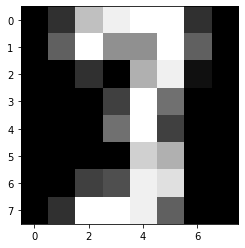

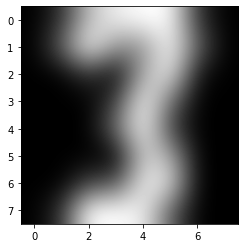

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import model_selection

digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# Filtering the dataset for threes zipped together with datapoint index
threes = [(index, number) for (index, number) in enumerate(target) if number == 3]
# Selecting a random image of a three
random_three = threes[np.random.randint(0, len(threes))][0]
img = images[random_three]

assert 2 == len(img.shape)

# Showing the three with imshow with interpolation nearest and bicubic
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()
plt.imshow(img, interpolation="bicubic")
plt.show()

# Splitting data in test and train set
X_all = data
y_all = target
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(digits.data, digits.target,
                                                                    test_size=0.4, random_state=0)

### Distance function computation using loops
We calculate the distance by subtracting the train point form the test point and then calculating the scalar product of the difference with itself. Afterwards we are calculating the square root of the scalar product, which is then the euclidean distance.

In [54]:
def dist_loop(training, test):
    N = len(training)
    M = len(test)

    output = np.empty((N, M))

    for n, train_point in enumerate(training):
        for m, test_point in enumerate(test):
            diff = test_point - train_point
            product = diff @ diff
            distance = np.sqrt(product)
            output[n][m] = distance

    return output


result = dist_loop(X_train, X_test)

### Distance function computation using vectorization
First a subtraction of the two matrices along the D dimension is done, (NxD, MxD) => (NxMxD) where the new output dimension contains the elementwise subtracted values per train and test image vector.
Afterwards every element is squared and the D dimension is reduced to a scalar by adding all values of the dimension together.
Last but not least the square root is calculated per element, which results in the euclidean distance returned in a NxM matrix.

In [55]:
def dist_vec(train, test) -> np.ndarray:
    diff = train[:, np.newaxis] - test
    product = diff ** 2
    distance = np.sqrt(np.add.reduce(product, axis=2))
    return distance


#### Evaluation
Testing that the results are equal:

In [56]:
np.array_equal(dist_loop(X_train, X_test), dist_vec(X_train, X_test))


True

Testing that which implementation is faster:

In [57]:
print('Loop implementation performance:')
%timeit dist_loop(X_train, X_test)

print('Vector implementation performance:')
%timeit dist_loop(X_train, X_test)

Loop implementation performance:
2.8 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vector implementation performance:
2.79 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### k-Nearest Neighbor
At first for the input the distance to evers train point is calculated.
With `argpartition` the sorted indices of the train set for the distance is calculated for every test point and the first k indices are taken (train-indices for the smallest distances per test point)
Afterwards the train-indices are converted to the y_train values (nearest train points) per test point.
With `scipy.stats.mode` the most common y value is returned per test point and a y vector is returned with the most probable values.

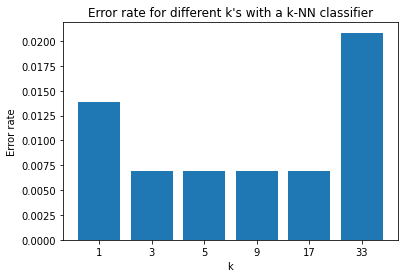

In [58]:
def k_nearest_neighbor(x_train, y_train, test, k):
    dist_matrix = dist_vec(x_train, test)
    knn_index_matrix: np.ndarray = dist_matrix.argpartition(k, axis=0)[:k, ]
    mapper = np.vectorize(lambda indices: y_train[indices])
    return mapper(knn_index_matrix).transpose()


def argmax_classifier(knn_mat):
    mode = stats.mode(knn_mat, axis=1)
    return mode[0].flatten()


def error_count(y_test: np.ndarray, y_test_calc: np.ndarray):
    y_diff = y_test - y_test_calc

    y_err = np.count_nonzero(y_diff)
    return np.sum(y_err)


def filter_dataset(x, y):
    x_filtered = []
    y_filtered = []
    for x, y in zip(x, y):
        if y == 3 or y == 9:
            x_filtered.append(x)
            y_filtered.append(y)
    return np.array(x_filtered), np.array(y_filtered)


x_train_filtered, y_train_filtered = filter_dataset(X_train, Y_train)
x_test_filtered, y_test_filtered = filter_dataset(X_test, Y_test)

ks = [1, 3, 5, 9, 17, 33]
errors = []


def k_nn_with_error_calc(x_tr, y_tr, x_te, y_te, k_n):
    knn_matrix = k_nearest_neighbor(x_tr, y_tr, x_te, k_n)
    y_test_calculated = argmax_classifier(knn_matrix)
    error = error_count(y_te, y_test_calculated)
    return error / len(y_te)


for k in ks:
    error_rate = k_nn_with_error_calc(x_train_filtered, y_train_filtered, x_test_filtered, y_test_filtered, k)
    errors.append(error_rate)

xs = range(len(ks))
plt.bar(xs, errors)
plt.xlabel('k')
plt.ylabel('Error rate')
plt.title("Error rate for different k's with a k-NN classifier")
plt.xticks(xs, ks)
plt.show()

## Cross validation
First the cross validation datasets are created. We shuffle indices with `np.permutate` and afterwards sort the X and Y data according these indices.

Then our kNN classifier is applied for every cross-validation combination for k ∈ {1, 3, 5, 9, 17, 33} as well as the scikit-learn classifier. The mean and standard deviation for each k is calculated and displayed in one plot per cross-validation split size.

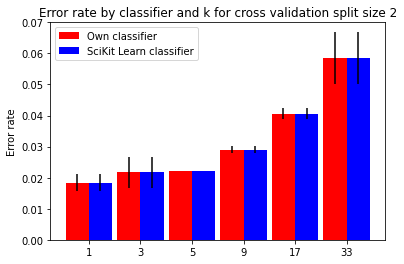

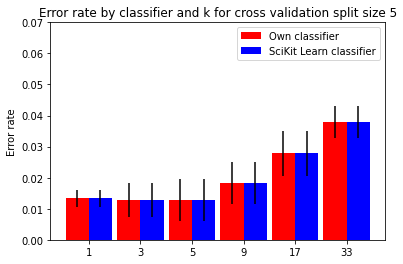

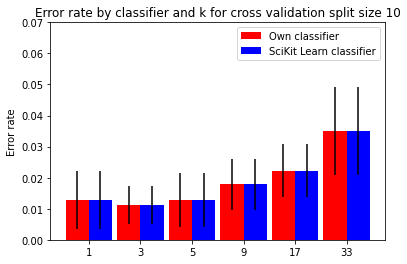

In [59]:
def split_folds(x, y, parts):
    perm = np.random.permutation(len(x))
    x_s, y_s = x[perm], y[perm]
    return np.array_split(x_s, parts), np.array_split(y_s, parts)


part_count = [2, 5, 10]
k_s = [1, 3, 5, 9, 17, 33]

for part_size in part_count:
    X_folds, Y_folds = split_folds(X_all, y_all, part_size)
    own_error_means_pp = []
    own_error_stds_pp = []
    skl_error_means_pp = []
    skl_error_stds_pp = []

    for k in k_s:
        own_errors = []
        skl_errors = []

        for validation_index in range(part_size):
            if part_size > 2:
                x_train = np.vstack(X_folds[:validation_index] + X_folds[validation_index + 1:])
                y_train = np.concatenate(Y_folds[:validation_index] + Y_folds[validation_index + 1:])
            else:
                x_train = np.array(X_folds[:validation_index] + X_folds[validation_index + 1:])
                y_train = np.array(Y_folds[:validation_index] + Y_folds[validation_index + 1:])
                x_train = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
                y_train = y_train.reshape((y_train.shape[0] * y_train.shape[1]))

            x_valid = X_folds[validation_index]
            y_valid = Y_folds[validation_index]

            error_rate = k_nn_with_error_calc(x_train, y_train, x_valid, y_valid, k)
            own_errors.append(error_rate)

            skl_knn = KNeighborsClassifier(k)
            skl_knn.fit(x_train, y_train)

            y_valid_pred_skl = skl_knn.predict(x_valid)
            error_count_skl = error_count(y_valid, y_valid_pred_skl)
            error_rate_skl = error_count_skl / len(y_valid)
            skl_errors.append(error_rate_skl)


        own_error_mean = np.mean(own_errors)
        own_error_std = np.std(own_errors)

        own_error_means_pp.append(own_error_mean)
        own_error_stds_pp.append(own_error_std)

        skl_error_mean = np.mean(skl_errors)
        skl_error_std = np.std(skl_errors)

        skl_error_means_pp.append(skl_error_mean)
        skl_error_stds_pp.append(skl_error_std)

    x_ind = np.array([i for i in range(len(k_s))])
    width = 0.45
    fig, ax = plt.subplots()
    own_rects = ax.bar(x_ind, own_error_means_pp, width, color='r', yerr=own_error_stds_pp)
    skl_rects = ax.bar(x_ind + width, skl_error_means_pp, width, color='blue', yerr=skl_error_stds_pp)

    ax.set_ylabel('Error rate')
    ax.set_ylim(ymin=0, ymax=.07)
    ax.set_title(f'Error rate by classifier and k for cross validation split size {part_size}')
    ax.set_xticks(x_ind + width / 2)
    ax.set_xticklabels(k_s)

    ax.legend((own_rects[0], skl_rects[0]), ('Own classifier', 'SciKit Learn classifier'))

    plt.show()